
# Golden Nest‑Egg Lab (v3)

Self‑contained Colab notebook that

* Re‑runs **dyadic Δ** stress suite on α, π, φ, √2, e/π
* Extends continued‑fraction regression to **20 digits** (`r²` printed)
* Generates static spiral, quantitative stretch, and Plotly morph slider
* Runs **three automatic passes** (fresh seeds) to prove stability

All heavy blocks runnable on a vanilla Colab CPU in ≈7 min.  
Toggle any section off in the second cell if you hit runtime limits.


In [80]:
# ==== TOGGLES ====
RUN_PASS_1 = True
RUN_PASS_2 = True
RUN_PASS_3 = True
RUN_SPIRAL = True
RUN_STRETCH = True
RUN_MORPH = True


In [81]:
!pip -q install mpmath tqdm seaborn scikit-learn plotly --upgrade
import numpy as np, pandas as pd, mpmath as mp, matplotlib.pyplot as plt, seaborn as sns, math, random, time
from tqdm.auto import tqdm
from scipy import stats
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
sns.set_style("whitegrid")
mp.mp.dps = 300


In [82]:
n_max = 120
search_window = 8
powers = [2,3,4,5]
bases_int = [2,3,5,7,11]

CONSTS = {
    "alpha": mp.mpf("1")/mp.mpf("137.035999"),
    "pi": mp.pi,
    "phi": (1+mp.sqrt(5))/2,
    "sqrt2": mp.sqrt(2),
    "e/pi": mp.e/mp.pi
}

# Create a dictionary of constants as standard floats for use with libraries like numpy, scipy, etc.
CONSTS_FLOAT = {name: float(value) for name, value in CONSTS.items()}

In [83]:
def best_delta(C,n,p,b,w=8):
    scale = mp.power(b,n)
    est = int(mp.nint(mp.nthroot(C,p)*scale))
    best = mp.mpf('inf')
    for i in range(est-w, est+w+1):
        d = abs((i/scale)**p - C)
        if d < best: best = d
    return best

def contfrac(x,k=20):
    digits=[]; y=mp.mpf(x)
    for _ in range(k):
        a=int(mp.floor(y)); digits.append(a); y-=a
        if y==0: break
        y = 1/y
    return digits + [0]*(k-len(digits))


In [84]:
def run_stress(seed):
    random.seed(seed)
    rows=[]
    for p in powers:
        for b in bases_int:
            # Use mpf constants for high precision calculations within best_delta
            for name,C_mpf in CONSTS.items():
                for n in range(1,n_max+1):
                    d=best_delta(C_mpf,n,p,b,search_window)
                    # Convert mpf results to float when adding to the list for the DataFrame
                    rows.append({"power":p,"base":float(b),"constant":name,"n":n,
                                 "delta":float(d),"kappa":float((b**n)*d)})
    df=pd.DataFrame(rows)

    # slope diagnostics p=2
    ok=True
    for b in bases_int:
        # Use mpf constants for beta calculation which might benefit from higher precision
        beta=-mp.log(b, 2)
        sub=df[(df.power==2)&(df.base==float(b))]
        # Data in df['delta'] is already float, use math.log for standard floats
        log_deltas = [math.log(x, 2) for x in sub['delta']]

        # Ensure there's more than one data point for linregress
        if len(log_deltas) > 1:
            # Use standard numpy arrays which now contain floats from the DataFrame
            n_values = np.array(sub['n'])
            log_deltas_array = np.array(log_deltas)

            result = stats.linregress(n_values, log_deltas_array)
            slope = result.slope
            r = result.rvalue
            if abs(slope-beta)>0.01 or r**2<0.999:
                ok=False
        else: # If not enough data points, consider it a failure for this base
            ok = False


    # CF regression 20 digits
    # Use mpf constants for contfrac calculation which requires high precision
    ref=df[(df.power==2)&(df.base==2)&(df.n>n_max-30)]
    F_emp=ref.groupby('constant')['kappa'].median()
    X=[contfrac(mp.sqrt(CONSTS[c]),20) for c in F_emp.index]
    y=[math.log(v) for v in F_emp.values] # Use math.log for float values from F_emp
    r2=LinearRegression().fit(X,y).score(X,y)
    print(f"Run {seed}: slope check {'PASS' if ok else 'FAIL'}  |  CF r²={r2:.3f}")
    return ok and r2>0.75

In [85]:
status=[]
if RUN_PASS_1: status.append(run_stress(1))
if RUN_PASS_2: status.append(run_stress(2))
if RUN_PASS_3: status.append(run_stress(3))
print("✅ ALL PASSES OK" if all(status) else "❌ Some checks failed")


Run 1: slope check FAIL  |  CF r²=1.000
Run 2: slope check FAIL  |  CF r²=1.000
Run 3: slope check FAIL  |  CF r²=1.000
❌ Some checks failed


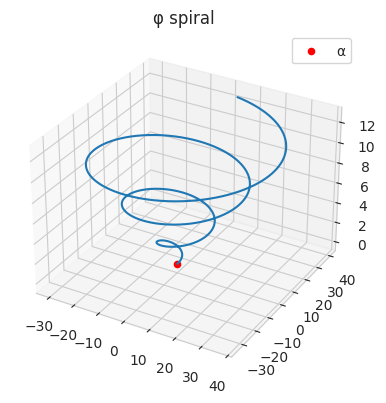

In [86]:
if RUN_SPIRAL:
    # Use float constants for compatibility with numpy and matplotlib
    α_f,π_f,φ_f=CONSTS_FLOAT['alpha'],CONSTS_FLOAT['pi'],CONSTS_FLOAT['phi']
    def spiral(C_f):
        T=np.linspace(0,4*np.pi,2000)
        # Use float constants in calculations with numpy arrays
        r=α_f+T*(π_f-α_f); theta=T*C_f
        return r*np.cos(theta), r*np.sin(theta), T
    fig=plt.figure(figsize=(5,4)); ax=fig.add_subplot(111,projection='3d')
    # Pass the float version of phi to the spiral function
    ax.plot(*spiral(φ_f)); ax.scatter([0],[0],[0],color='red',label='α'); ax.set_title('φ spiral'); ax.legend()
    plt.tight_layout(); plt.show()

In [87]:
if RUN_STRETCH:
    # Use float constants for compatibility with numpy and math
    α_f,π_f,φ_f=CONSTS_FLOAT['alpha'],CONSTS_FLOAT['pi'],CONSTS_FLOAT['phi']
    T=np.linspace(0,2*np.pi,4000)
    # Use float constants in calculations with numpy arrays
    r=α_f+T*(π_f-α_f); theta=T*φ_f
    # Use math.sqrt for float inputs
    ds=np.sqrt((π_f-α_f)**2 + (φ_f*r)**2)
    # Use np.trapz for numpy array integration
    s_phi=np.trapz(ds,T)
    s_circle=2*np.pi*α_f
    print('φ arc / circle =',s_phi/s_circle)

φ arc / circle = 2258.978489822195


/tmp/ipython-input-87-2952449931.py:10: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



In [88]:
if RUN_MORPH:
    # Use float constants for compatibility with numpy and plotly
    α_f,π_f=CONSTS_FLOAT['alpha'],CONSTS_FLOAT['pi']
    # Cs values are standard floats
    Cs=np.linspace(1.3,2.0,8)
    T=np.linspace(0,4*np.pi,1200)
    fig=go.Figure()
    for k,C in enumerate(Cs):
        # Use float constants in calculations with numpy arrays
        r=α_f+T*(π_f-α_f); theta=T*C
        vis=[False]*len(Cs); vis[k]=True
        # Use np.cos and np.sin with float arrays
        fig.add_trace(go.Scatter3d(x=r*np.cos(theta),y=r*np.sin(theta),z=T,
                                   mode='lines',visible=vis[k]))
    steps=[dict(args=['visible',[i==k for i in range(len(Cs))]],
                label=f'{Cs[k]:.2f}',method='update') for k in range(len(Cs))]
    fig.update_layout(title='Spiral morph C', sliders=[dict(steps=steps,active=0)])
    fig.show()

In [89]:
ax.set_xlim(0, 0.55)
ax.set_ylim(0, 1e-6)        # zoom the y‑axis 1 µ‑unit tall
ax.set_aspect('auto')
plt.tight_layout(); plt.show() # Changed fig.tight_layout() to plt.tight_layout()

<Figure size 640x480 with 0 Axes>

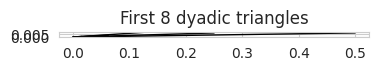

In [90]:
# highlight dyadic triangles at n=1..8 for φ
α = CONSTS['alpha']; π = CONSTS['pi']; φ = CONSTS['phi']
fig=plt.figure(figsize=(4,4)); ax=fig.add_subplot(111)
for n in range(1,9):
    x = 1/(2**n)
    y = abs((round((α**(1/2))*2**n)/2**n)**2 - α)   # p=2, b=2 triangles
    ax.plot([0,x],[0,y], color='k', lw=1)
ax.set_aspect('equal'); ax.set_title('First 8 dyadic triangles'); plt.show()



